# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

*Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?*

This problem is best suited for classificaton. This is due to the binary nature of the output, where we require a determination of the student as "need early intervention", or not. The current problem does not include a need to predict a specific value, such as a grade, for each student. If it did, this would be a regression problem.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [54]:
# Import libraries
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display
%matplotlib inline  


In [42]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns


Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [45]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students =student_data.shape[0]
n_features = student_data.shape[1]-1
n_passed = student_data[student_data['passed']=='yes'].shape[0]
n_failed = student_data[student_data['passed']=='no'].shape[0]
grad_rate = n_passed/float(n_students)*100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
#y_all = y_all.replace(['yes', 'no'], [1, 0]) #swap yes/no to a numeric
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [48]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset

from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split( X_all, y_all, test_size=num_test, random_state=40)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

#### Experimentation showed three different models that may best classify the data: LogisticRegression, AdaBoost, and KNeighbors.

####  Logistic Regression
 * Space& Complexity - LogisticRegression is fast to query(test/train Delta), and is an eager learner, implying a lower resource usage and quicker prediction times.
 
 * General Applications(strengths/weaknesses) - This model is used for binary classification type problems.It has many advantages, including speed, and it may be able to avoid overfitting in many cases. It does require more data to perform at it's best, as can be seen in the charts above. Additionally, the data should be linearly seperable.
 
 * Why this model? This model is a good fit due to it's classification capabilities and it's speed. Another advantage in this case is that it is possible to output a probability, to use, for instance, as a probability that a student is in need of intervention.

#### AdaBoost 
 * Space& Complexity - AdaBoost is a boost algorithim, and we can see that it has the longest training time in any of the candidates (by 2 order of magnitude), although prediction time is good. 
 
 * General Applications(strengths/weaknesses) - AdaBoost is a powerful classifier that has the advantage of needing less configuration to acheive good results, as well as being good at avoiding overfitting due to the use of multiple weak learners. It is however more sensitive to noisy data, and has very high resource usage.
 
 * Why this model? This model may be a good fit to it's ability to acheive good results with little training, and the ability to avoid overfitting the data

#### KNeighbors
* Space& Complexity - KNeighbors is a lazy learner, and requires more memory resources, although training time is very fast. Prediction time(testDelta&trainDelta) are highest of the candidates. This model uses the neighbors with similar features features to predict the label.

* General Applications(strengths/weaknesses) - KNeighbors ability as a binary classifier make it an appropriate candidate. It has the advantage of quick training, but is held back by slowed prediction time. It also has an advantage in that data may be added to the model easily as it is aquired. 

* Why this model? This model has the advantage of speedy training with good accuracy as a classifier, and would be well suited to an application that continuously adds data but has a reduced need for predictions.

In [58]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Fit model to training data
print "Training {}...".format(clf.__class__.__name__)
timeDelta=train_classifier(clf, X_train, y_train)  # note: using entire training set here
print "Done!\nTraining time (secs): {:.3f}".format(timeDelta)
print clf  # you can inspect the learned model by printing it

Training GaussianNB...
Done!
Training time (secs): 0.002
GaussianNB()


In [59]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes'),end - start

print "Predicting labels using {}...".format(clf.__class__.__name__)
train_f1_score,timeDelta = predict_labels(clf, X_train, y_train)
print "Done!\nPrediction time (secs): {:.3f}".format(timeDelta)
print "F1 score for training set: {}".format(train_f1_score)


Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.777506112469


In [60]:
# Predict on test data

print "Predicting labels using {}...".format(clf.__class__.__name__)
test_f1_score,timeDelta = predict_labels(clf, X_train, y_train)
print "Done!\nPrediction time (secs): {:.3f}".format(timeDelta)
print "F1 score for test set: {}".format(test_f1_score)

Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.777506112469


In [61]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
print "------------------------------------------"
print "Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain)
print "F1 score for training set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta)
print "F1 score for test set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta)


------------------------------------------
Training set size: 300, Train time (secs): 0.001
F1 score for training set: 0.797101449275, Prediction time (secs): 0.001
F1 score for test set: 0.777506112469, Prediction time (secs): 0.001


In [62]:
# TODO: Train and predict using two other models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble
from sklearn.naive_bayes import GaussianNB
#from sklearn.neural_network import MLPClassifier # not in vesion .17

def runCLF(X_train, y_train, X_test, y_test, runall=False):
    scores={}

    clf = KNeighborsClassifier(n_jobs =-1)
    scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

    clf=linear_model.LogisticRegression(n_jobs =-1)
    scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

    clf = ensemble.AdaBoostClassifier()
    scores[clf.__class__.__name__+"-plain"]= train_predict(clf, X_train, y_train, X_test, y_test)
    
    # for testing purposes, some other possible classifiers
    if runall == True:    
        clf = ensemble.AdaBoostClassifier(GaussianNB())
        scores[clf.__class__.__name__+"-GNB"]= train_predict(clf, X_train, y_train, X_test, y_test)

        clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,class_weight ="balanced"))
        scores[clf.__class__.__name__+"-DCT"]= train_predict(clf, X_train, y_train, X_test, y_test)

        clf = ensemble.RandomForestClassifier(n_jobs =-1,class_weight="balanced")
        scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

        clf = DecisionTreeClassifier(class_weight ="balanced")
        scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

        clf=LinearSVC(class_weight="balanced")
        scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

        clf=SVC(class_weight='balanced')
        scores[clf.__class__.__name__]= train_predict(clf, X_train, y_train, X_test, y_test)

    scoresDF= pd.DataFrame(scores,index=['testF1','testDelta','trainF1','trainDelta','timeToTrain']).T
    return scoresDF.sort_values('testF1',ascending=False)

 
runs = 3
holdData=[]
for r in range(runs) :
    runNum=(r+1)*100
    print "calculating the" ,runNum,"set"
    holdData.append([runNum,runCLF(X_train[:runNum], y_train[:runNum], X_test, y_test, runall=False)])
   


calculating the 100 set
calculating the 200 set
calculating the 300 set



training data size: 100


,testF1,testDelta,trainF1,trainDelta,timeToTrain
LogisticRegression,0.771429,0.000,0.885906,0.000,0.003
KNeighborsClassifier,0.741259,0.126,0.847682,0.118,0.000
AdaBoostClassifier-plain,0.725926,0.005,0.992806,0.006,0.098



training data size: 200


,testF1,testDelta,trainF1,trainDelta,timeToTrain
LogisticRegression,0.841379,0.001,0.825503,0.001,0.006
AdaBoostClassifier-plain,0.833333,0.005,0.868966,0.006,0.106
KNeighborsClassifier,0.744828,0.119,0.821053,0.119,0.001



training data size: 300


,testF1,testDelta,trainF1,trainDelta,timeToTrain
AdaBoostClassifier-plain,0.823529,0.005,0.860520,0.006,0.102
LogisticRegression,0.816901,0.000,0.822727,0.000,0.003
KNeighborsClassifier,0.783784,0.117,0.850467,0.121,0.003


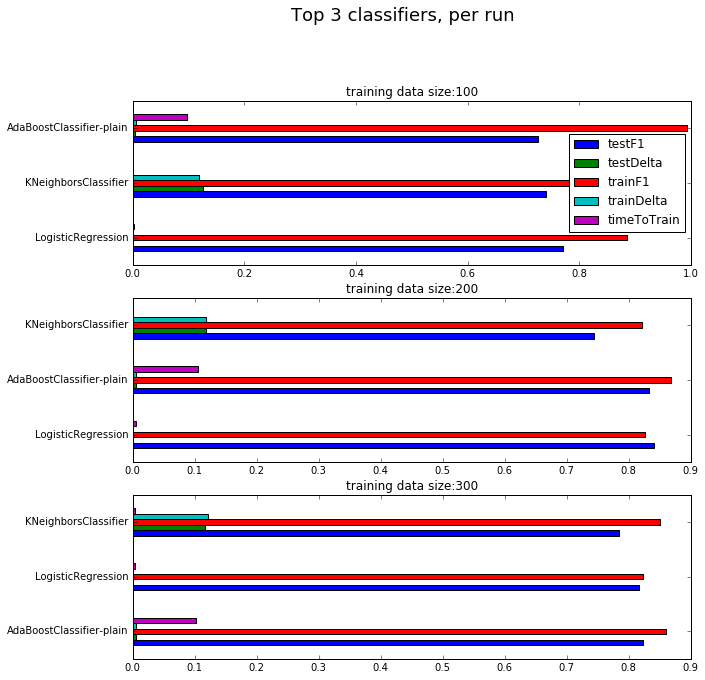

In [96]:
fig, axes = plt.subplots(nrows=3, ncols=1)
i=0
leg=True
for h in holdData:
    print "\ntraining data size:",h[0]
    display( h[1][['testF1','testDelta','trainF1','trainDelta','timeToTrain']][:3])
    h[1][['testF1','testDelta','trainF1','trainDelta','timeToTrain']][:3].plot(
                                                                            kind='barh',
                                                                            ax=axes[i],
                                                                            legend=leg,
                                                                            figsize=(10,10),
                                                                            title="\ntraining data size:"+str(h[0]))
    leg=False
    i+=1
    
fig.suptitle('Top 3 classifiers, per run', fontsize=18, y=1.03)
#fig.figsize=(10,8)
fig.show()

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

We have selected Logistic Regression as our initial classifier due to it's speed and low resource usage. As more data is added to the model, we should continue to expect lower resource usage and prediction speed. We also have the possibility to express prediction about students as a probability of the need for intervention. As compared to the other tested classifiers, we may see that time taken for prediction is very significantly lower than KNeighbors, and it's training time (as well as prediction time) is significantly lower than AdaBoost. While these may have been a good reason to choose the model, it also happens that it has performed within a few percentage points of a tuned AdaBoost, and better than a tuned Kneighbors. 

Logistic Regression works by coming up with a probability function based on the training data that can give us the chance that an input may belong to one of the classes. It works out the function by fitting the data to an s-shaped(sigmoid) distribution, based on the frequency within the data. A prediction is made by using this function to output a position within the distribution, giving us a probability that the input is in the class or not.

After tuning the model below we see a final score of F1 score: 0.0.83870. 

In [91]:
# TODO: Fine-tune your model and report the best F1 score

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.cross_validation import StratifiedShuffleSplit

def modelTune(clf, params, X, y):
    #Fine tune model with grid search
    grid_search = GridSearchCV(clf, 
                               param_grid=params, 
                               cv=StratifiedShuffleSplit(y,n_iter=50, random_state=42), 
                               n_jobs= 5, # num CPU*2+1 is a good guide, and should allow good CPU utilization.
                               scoring=make_scorer(f1_score, 
                                                   pos_label="yes",
                                                   greater_is_better=True)) 

    grid_search.fit(X, y)

    #reach into the grid search and pull out the best parameters, and set those on clf. probably not necesary, but easier to deal with
    bestGridParams={}
    for bp in grid_search.best_params_:
        bestGridParams[bp]=grid_search.best_params_[bp]
    clf.set_params(**bestGridParams)
    return clf

    # Check out each parameter combination and it's score:
    #for gs in grid_search.grid_scores_:
    #    print gs


In [92]:

print "best classifier was:"
clf=linear_model.LogisticRegression(n_jobs =-1)

params={'C' : [8,1.,.8,.08,.008],
        'fit_intercept' : [True, False],
        'class_weight': [ None,'balanced'],
        #'random_state' : [None,42],
        #'solver' : ['newton-cg', 'lbfgs', 'liblinear'],#, 'sag'],
        'tol': [0.00001,0.0001,.001],
        'penalty': ['l1', 'l2']
       }
print "\nOriginal clf:\n",clf #compare after gridsearch
test_def,testDelta_def,train_def,trainDelta_def,timeTrainf_def=train_predict(clf, X_train, y_train, X_test, y_test)

clf_tuned=modelTune(clf, params,X_train,y_train)
test_GS,testDelta_GS,train_GS,trainDelta_GS,timeTrainf_GS=train_predict(clf_tuned, X_train, y_train, X_test, y_test)

print "GridSearch best clf:\n",clf_tuned 

# the dataset is small gridsearch may not provide a better set of parameters than the default
# We'll check for that situation and return the best options F1 score for the full data set
print "------------------------------------------"
if test_GS >test_def: 
    print "\nFinal clf_GS, F1 score:",test_GS," def F1:",test_def,"\n" #after gridseach

else:
    print "\nFinal clf_def, F1 score:",test_def," GS F1:",test_GS,"\n" #after gridseach

best classifier was:

Original clf:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
GridSearch best clf:
LogisticRegression(C=0.08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False)
------------------------------------------

Final clf_GS, F1 score: 0.838709677419  def F1: 0.816901408451 



In [94]:
clf=ensemble.AdaBoostClassifier()
params={'n_estimators' : [13,25,50,60], 
        'learning_rate' :[.8,.96,1,1.4]
       }
print "next best: AdaBoostClassifier\n",clf
test_def,testDelta_def,train_def,trainDelta_def,timeTrainf_def=train_predict(clf, X_train, y_train, X_test, y_test)

clf_tuned=modelTune(clf, params,X_train,y_train)
test_GS,testDelta_GS,train_GS,trainDelta_GS,timeTrainf_GS=train_predict(clf_tuned, X_train, y_train, X_test, y_test)

print "GridSearch best clf:\n",clf_tuned 

# the dataset is small gridsearch may not provide a better set of parameters than the default
# We'll check for that situation and return the best options F1 score for the full data set
print "------------------------------------------"
if test_GS >test_def: 
    print "\nFinal clf_GS, F1 score:",test_GS," def F1:",test_def,"\n" #after gridseach

else:
    print "\nFinal clf_def, F1 score:",test_def," GS F1:",test_GS,"\n" #after gridseach

next best: AdaBoostClassifier
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
GridSearch best clf:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.8, n_estimators=13, random_state=None)
------------------------------------------

Final clf_GS, F1 score: 0.830985915493  def F1: 0.823529411765 



In [89]:
clf=KNeighborsClassifier(n_jobs =-1)
params={'leaf_size' : [7,15,22,30,60], 
        'n_neighbors' : [5,15,25,37,45], 
        #'weights':['uniform','distance'], 
        'p':[1,2]
       }
print "next best: KNeighborsClassifier\n",clf
test_def,testDelta_def,train_def,trainDelta_def,timeTrainf_def=train_predict(clf, X_train, y_train, X_test, y_test)

clf_tuned=modelTune(clf, params,X_train,y_train)
test_GS,testDelta_GS,train_GS,trainDelta_GS,timeTrainf_GS=train_predict(clf_tuned, X_train, y_train, X_test, y_test)

print "GridSearch best clf:\n",clf_tuned 

# the dataset is small gridsearch may not provide a better set of parameters than the default
# We'll check for that situation and return the best options F1 score for the full data set
print "------------------------------------------"
if test_GS >test_def: 
    print "\nFinal clf_GS, F1 score:",test_GS," def F1:",test_def,"\n" #after gridseach

else:
    print "\nFinal clf_def, F1 score:",test_def," GS F1:",test_GS,"\n" #after gridseach

next best: KNeighborsClassifier
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
GridSearch best clf:
KNeighborsClassifier(algorithm='auto', leaf_size=15, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=37, p=1,
           weights='uniform')
------------------------------------------

Final clf_GS, F1 score: 0.825  def F1: 0.783783783784 



#EOF